In [1]:
from glob import glob 

for g in glob('../data/*.pdf'):
    print(g)

../data\2040_seoul_plan.pdf
../data\OneNYC_2050_Strategic_Plan.pdf


In [2]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

def read_pdf_and_split_text(pdf_path, chunk_size=1000, chunk_overlap=100):
    """
    주어진 PDF 파일을 읽고 텍스트를 분할합니다.
    매개변수:
        pdf_path (str): PDF 파일의 경로.
        chunk_size (int, 선택적): 각 텍스트 청크의 크기. 기본값은 1000입니다.
        chunk_overlap (int, 선택적): 청크 간의 중첩 크기. 기본값은 100입니다.
    반환값:
        list: 분할된 텍스트 청크의 리스트.
    """
    print(f"PDF: {pdf_path} -----------------------------")

    pdf_loader = PyPDFLoader(pdf_path)
    data_from_pdf = pdf_loader.load()

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )

    splits = text_splitter.split_documents(data_from_pdf)
    
    print(f"Number of splits: {len(splits)}\n")
    return splits


In [3]:
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
import os

##### Vectorstore 설정 #####
embedding = OpenAIEmbeddings(model='text-embedding-3-large')

persist_directory='../chroma_store'

if os.path.exists(persist_directory):
    print("Loading existing Chroma store")
    vectorstore = Chroma(
        persist_directory=persist_directory, 
        embedding_function=embedding
    )
else:
    print("Creating new Chroma store")
    
    vectorstore = None
    for g in glob('../data/*.pdf'):
        chunks = read_pdf_and_split_text(g)
        # 100개씩 나눠서 저장
        for i in range(0, len(chunks), 100):
            if vectorstore is None:
                vectorstore = Chroma.from_documents(
                    documents=chunks[i:i+100],
                    embedding=embedding,
                    persist_directory=persist_directory
                )
            else:
                vectorstore.add_documents(
                    documents=chunks[i:i+100]
                )


Creating new Chroma store
PDF: ../data\2040_seoul_plan.pdf -----------------------------
Number of splits: 308

PDF: ../data\OneNYC_2050_Strategic_Plan.pdf -----------------------------
Number of splits: 1023



In [5]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

chunks = retriever.invoke("서울 온실가스 저감 계획")

for chunk in chunks:
    print(chunk.metadata)
    print(chunk.page_content)


{'author': 'SI', 'creationdate': '2024-12-12T18:16:11+09:00', 'creator': 'Hwp 2020 11.0.0.5178', 'moddate': '2024-12-12T18:16:11+09:00', 'page': 63, 'page_label': '64', 'pdfversion': '1.4', 'producer': 'Hancom PDF 1.3.0.542', 'source': '../data\\2040_seoul_plan.pdf', 'total_pages': 205}
56제2장 미래상과 목표
6. 미래위기를 준비하는, ‘탄소중립 안전도시 구축’1) 배경전(全) 지구적인 기후변화에 대응하기 위한 대도시 차원의 대응 필요Ÿ서울시 2017년 온실가스 배출량은 46,685천 톤CO2eq로 2005년 배출량에 비해 5.6%(276만 톤CO2eq) 감소하였으며, 서울의 1인당 온실가스 배출량은 4.7CO2eq로 국가의 13.8톤CO2eq에 비해 낮은 수준이다. 또한 2014년 기준 서울의 1인당 온실가스 배출량은 4.5CO2eq로 세계 주요 도시에 비해 낮은 수준을 보인다.7)
[그림 2-26] 세계 주요 도시 1인당 온실가스 배출량   자료: World Bank, 2014Ÿ그럼에도 불구하고, 기후변화 문제는 21세기에 전 지구적으로 가장 위중한 영향을 미칠 것으로 예상되는바, 탄소중립과 기후위기 대응은 국제·국가·도시의 핵심 정책으로 다루어져야 한다.Ÿ파리협정(2015) 이후, 우리나라를 비롯한 미국, 유럽연합 등 세계 136개국이 탄소중립을 선언하였으며, 서울시를 비롯한 뉴욕, 런던 등과 같은 많은 글로벌 도시에서 탄소중립을 시정의 핵심과제로 추진 중이다.Ÿ우리나라는 2020년 ‘한국판 그린뉴딜’을 발표하며 공식적으로 2050 탄소중립을 선언하였으며 서울시 역시 2020년 ‘그린뉴딜 추진을 통한 2050 온실가스 감축 전략’을 발표하고 탄소중립 선언에 따른 부문별 사업을 적극 추진하고 있다.-서울시는 2050년 탄소중립을 목

In [6]:
from langchain_openai import ChatOpenAI

# 모델 초기화
model = ChatOpenAI(model="gpt-4o-mini")
model.invoke('안녕하세요!')

AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 10, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-b1726e7a-35e9-4a5b-af5c-d82010778adb-0', usage_metadata={'input_tokens': 10, 'output_tokens': 11, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [7]:
# Router 설정
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal # 문자열 리터럴 타입을 지원하는 typing 모듈의 클래스
from pydantic import BaseModel, Field

# Data model
class RouteQuery(BaseModel):
    """사용자 쿼리를 가장 관련성이 높은 데이터 소스로 라우팅합니다."""
    
    datasource: Literal["vectorstore", "casual_talk"] = Field(
        ...,
        description="""
        사용자 질문에 따라 casual_talk 또는 vectorstore로 라우팅합니다.
        - casual_talk: 일상 대화를 위한 데이터 소스. 사용자가 일상적인 질문을 할 때 사용합니다.
        - vectorstore: 사용자 질문에 답하기 위해 RAG로 vectorstore 검색이 필요한 경우 사용합니다.
        """,
    )

In [8]:
# 특정 모델을 structured output (구조화된 출력)과 함께 사용하기 위해 설정
structured_llm_router = model.with_structured_output(RouteQuery)

router_system = """
당신은 사용자의 질문을 vectorstore 또는 casual_talk으로 라우팅하는 전문가입니다.
- vectorstore에는 서울, 뉴욕의 발전계획과 관련된 문서가 포함되어 있습니다. 이 주제에 대한 질문에는 vectorstore를 사용하십시오.
- 사용자의 질문이 일상 대화에 관련된 경우 casual_talk을 사용하십시오.
"""

# 시스템 메시지와 사용자의 질문을 포함하는 프롬프트 템플릿 생성
route_prompt = ChatPromptTemplate.from_messages([
    ("system", router_system),
    ("human", "{question}"),
])

# 라우터 프롬프트와 구조화된 출력 모델을 결합한 객체
question_router = route_prompt | structured_llm_router


In [9]:
print(
    question_router.invoke({
        "question": "서울 온실가스 저감 계획은 무엇인가요?"
    })
)

print(question_router.invoke({"question": "잘 지냈어?"}))

datasource='vectorstore'
datasource='casual_talk'


In [10]:
from langchain_core.prompts import PromptTemplate

class GradeDocuments(BaseModel):
    """검색된 문서가 질문과 관련성 있는지 yes 또는 no로 평가합니다."""

    binary_score: Literal["yes", "no"] = Field(
        description="문서가 질문과 관련이 있는지 여부를 'yes' 또는 'no'로 평가합니다."
    )

structured_llm_grader = model.with_structured_output(GradeDocuments)

In [32]:
grader_prompt = PromptTemplate.from_template("""
당신은 검색된 문서가 사용자 질문과 관련이 있는지 평가하는 평가자입니다. \n 
문서에 사용자 질문과 관련된 키워드 또는 의미가 포함되어 있으면, 해당 문서를 관련성이 있다고 평가하십시오. \n
엄격한 테스트가 필요하지 않습니다. 목표는 잘못된 검색 결과를 걸러내는 것입니다. \n
문서가 질문과 관련이 있는지 여부를 나타내기 위해 'yes' 또는 'no'로 이진 점수를 부여하십시오.
                                             
Retrieved document: \n {document} \n\n 
User question: {question}
""")

retrieval_grader = grader_prompt | structured_llm_grader
question = "서울시 자율주행 관련 계획"
documents = retriever.invoke(question)

for doc in documents:
    print(doc)


page_content='54제2장 미래상과 목표
5. 기술발전에 선제적 대응, ‘미래교통 인프라 구축’1) 배경미래교통수단 도입에 따른 도시 활동 변화 및 공간구조 재편 대비Ÿ빠르게 진화하는 미래 신 교통수단은 도시공간에 새로운 변화를 일으킬 것이며, 도시 내 이동패턴의 변화를 가져올 것으로 예측된다. 이러한 점을 고려하여 도시 내 다양한 통행행태가 공존하는 포용적인 교통체계 구축을 준비해야 한다.미래교통수단 정착을 위한 도시 인프라 확충지원 필요Ÿ기존에 없던 새로운 교통은 통상 인프라 구축에 많은 시간이 소요되기 때문에 교통수단이 도입된 이후에 준비하기보다는 개발단계에서부터 이를 지원하기 위한 교통인프라 구축 구상이 요구되며, 새로운 도시 인프라 확충에 대한 도시계획적 지원이 필요하다.2) 추진전략자율주행 자동차 본격 운영 체계 구축Ÿ자율주행은 현재 제일 가시화되고 있는 미래 교통기술로 시장의 주도권을 확보하기 위해 각국의 노력이 집중되고 있다. 단계적으로 2030년까지 간선도로급 이상 도로에서 운영할 수 있는 도로 인프라 환경을 조성하고, 2040년까지 서울 전역 자율주행 운행 환경 구축을 목표로 한다.-2040년까지 서울 전역 자율주행차량의 운행 환경을 구축하고 수송 분담률 10%를 달성서울형 도심 항공교통 기반 마련 및 터미널 확충Ÿ도심에서 김포공항까지 시범노선을 운영하는 등 상용화 노선을 확보하고, 장기적으로 한강, 지천 등 주요 수변 공간 중심으로 광역노선을 확보한다. 또한 UAM 인프라 확보를 위한 인센티브 및 도시계획적인 지원 방안도 함께 검토한다.-UAM 시범노선을 운영하고, 한강 등 주요 수변 공간 중심에 단계적 광역노선을 확장서울 전역에 모빌리티 허브 구축Ÿ도심 및 광역거점에 서울 내부와 외부의 연계를 위한 미래 교통과 기존 교통을 연결하는 시설을 도입한다. 또한 교통뿐 아니라 공공서비스, 물류, 상업 등 다양한 기능들이 복합적으로 제공되는 지역 거점 모빌리티 허브를 서울 전역에 도입한다.' metadata={'author': 'SI', 

In [33]:
filtered_docs = []

for i, doc in enumerate(documents):
    print(f"Document {i + 1}:")
    is_relevant = retrieval_grader.invoke({"question": question, "document": doc.page_content})
    print(is_relevant)
    print(doc.page_content[:200])
    print("=================================\n\n")

    if is_relevant.binary_score == "yes":
        filtered_docs.append(doc)

print(f"Filtered documents: {len(filtered_docs)}")


Document 1:
binary_score='yes'
54제2장 미래상과 목표
5. 기술발전에 선제적 대응, ‘미래교통 인프라 구축’1) 배경미래교통수단 도입에 따른 도시 활동 변화 및 공간구조 재편 대비Ÿ빠르게 진화하는 미래 신 교통수단은 도시공간에 새로운 변화를 일으킬 것이며, 도시 내 이동패턴의 변화를 가져올 것으로 예측된다. 이러한 점을 고려하여 도시 내 다양한 통행행태가 공존하는 포용적인 교통체계 구


Document 2:
binary_score='yes'
36제2장 미래상과 목표
6) 미래교통수단의 등장과 첨단 인프라 요구 증대자율주행, UAM 등 미래 교통에 공간적 대응방안 마련 필요Ÿ자율주행차량, 전동킥보드 등 교통 기술의 발전에 따라 새로운 교통환경이 조성되고 있음에도 불구하고, 이에 대한 정착 가이드라인이 없어, 위험한 교통 사고가 유발되고 있다.-최근 3년간 서울시에서 발생한 전동킥보드 관련 사고 


Document 3:
binary_score='no'
제1절 도시공간구조105기능이 공존하는 미래 도심으로 조성-국제 디지털 금융중심지인 여의도·영등포는 한강을 중심으로 한 글로벌 혁신코어 조성-국제 업무 중심지인 강남은 영동대로와 경부간선도로의 입체복합화로 가용지를 확보하여 업무복합기능을 강화 Ÿ수도 서울의 위상 강화를 위해 “광화문~용산~영등포”축을 국가중심공간으로 조성한다.-북악산~청와대~광화문광장~서울


Document 4:
binary_score='yes'
광화문·시청역을, GTX-B 노선은 종로3가역 또는 동대문역 신설 제안을 검토Ÿ자전거를 비롯하여 개인용 이동수단(PM), 수상교통, 도심항공교통(UAM) 등 신 이동수단으로 도심 간 연결 수단을 다양화하고, 교통수단 상용화에 필요한 인프라를 구축한다.-여의도~잠실종합운동장, 남산공원~용산공원~용산역(정비창)~여의도 등을 연결하는 신 이동수단의 인프라 신설을


Document 5:
binary_score='no'
제3절 권역별 구상147보행 중심 교통체계 전환을 위한 친환경 

In [35]:
### Generate
# PromptTemplate을 사용하여 RAG를 위한 프롬프트를 생성합니다.

rag_generate_system = """
너는 사용자의 질문에 대해 주어진 context에 기반하여 답변하는 도시 계획 전문가이다. 
주어진 context는 vectorstore에서 검색된 결과이다. 
주어진 context를 기반으로 사용자의 question에 대해 답변하라.

=================================
question: {question}
context: {context}
"""

# PromptTemplate을 생성하여 question과 context를 포맷팅
rag_prompt = PromptTemplate(
    input_variables=["question", "context"],
    template=rag_generate_system
)

# rag chain
rag_chain = rag_prompt | model 

# 사용자 질문과 검색된 문서를 입력으로 사용하여 RAG를 실행
question = "서울시 자율주행 관련 계획"

rag_chain.invoke({"question": question, "context": filtered_docs})


AIMessage(content='서울시는 자율주행 교통수단 도입을 위해 단계적으로 계획을 마련하고 있습니다. 2030년까지는 간선도로급 이상의 도로에서 자율주행 자동차가 운영될 수 있는 인프라 환경을 조성하며, 2040년까지는 서울 전역에 자율주행 차량의 운행 환경을 구축할 목표를 세우고 있습니다. 이를 통해 자율주행 차량의 수송 분담률을 10%로 달성하고자 합니다.\n\n또한 도심 항공 교통(UAM)의 기반을 다지기 위해 김포공항까지의 시범 노선 운영을 포함하여, 한강과 같은 주요 수변 공간 중심으로 광역 노선도 확보할 계획입니다. 이와 함께, 서울 전역에는 모빌리티 허브를 구축하여 다양한 교통수단과 공공서비스, 물류, 상업적 기능을 통합적으로 제공하는 거점 시설도 도입할 예정입니다.\n\n이러한 여러 계획은 새로운 도시 공공 교통 체계에 대한 포괄적 접근을 통해 안전하고 효율적인 이동 환경을 만들고, 급변하는 교통 기술에 유연하게 대응하기 위한 것입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 259, 'prompt_tokens': 1794, 'total_tokens': 2053, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-d5ae0761-3b1d-4f9f-9f0f-6a221d

In [36]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    question: str   # 사용자 질문
    generation: str # LLM 생성 결과
    documents: List[str] # 검색된 문서


In [37]:
def route_question(state): 
    """
    사용자 질문을 vectorstore 또는 casual_talk로 라우팅합니다.
    
    Args:
        state (dict): 현재 graph state

    return:
        state (dict): 라우팅된 데이터 소스와 사용자 질문을 포함하는 새로운 graph state
    """
    print('------ROUTE------')
    question = state['question']
    route = question_router.invoke({"question": question})

    
    print(f"---Routing to {route.datasource}---")
    return route.datasource   

In [38]:
def retrieve(state): 
    """
    vectorstore에서 질문에 대한 문서를 검색합니다.
    
    Args:
        state (dict): 현재 graph state

    return:
        state (dict): 검색된 문서와 사용자 질문을 포함하는 새로운 graph state
    """
    print('------RETRIEVE------')
    question = state['question']

    # Retrieve documents
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [43]:
def grade_documents(state):
    """
    검색된 문서를 평가하여 질문과 관련성이 있는지 확인합니다.

    Args:
        state (dict): 현재 graph state

    return:
        state (dict): 관련성이 있는 문서와 사용자 질문을 포함하는 새로운 graph state
    """
    print('------GRADE------')
    question = state['question']
    documents = state['documents']
    filtered_docs = []

    for i, doc in enumerate(documents):
        is_relevant = retrieval_grader.invoke({"question": question, "document": doc.page_content})
        if is_relevant.binary_score == "yes":
            filtered_docs.append(doc)
    return {"documents": filtered_docs, "question": question}  

In [39]:
def generate(state):
    """
    LLM을 사용하여 문서와 사용자 질문에 대한 답변을 생성합니다.

    Args:
        state (dict): 현재 graph state

    return:
        state (dict): LLM 생성 결과와 사용자 질문을 포함하는 새로운 graph state
    """
    print('------GENERATE------')
    question = state['question']
    documents = state['documents']
    generation = rag_chain.invoke({"question": question, "context": documents})
    return {
        "documents": documents,
        "question": question,
        "generation": generation
    }

In [40]:
def casual_talk(state):
    """
    일상 대화를 위한 답변을 생성합니다.

    Args:
        state (dict): 현재 graph state

    return:
        state (dict): 일상 대화 결과와 사용자 질문을 포함하는 새로운 graph state
    """
    print('------CASUAL TALK------')
    question = state['question']
    generation = model.invoke(question)
    return {
        "question": question,
        "generation": generation
    }

In [45]:
from langgraph.graph import START, StateGraph, END

workflow = StateGraph(GraphState)

In [46]:
# 노드를 정의 
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("casual_talk", casual_talk)

In [47]:
# graph를 정의
workflow.add_conditional_edges(
    START, 
    route_question,
    {
        "vectorstore": "retrieve",
        "casual_talk": "casual_talk"
    }
)
workflow.add_edge("casual_talk", END)
workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("grade_documents", "generate")
workflow.add_edge("generate", END)

app = workflow.compile() # workflow를 컴파일

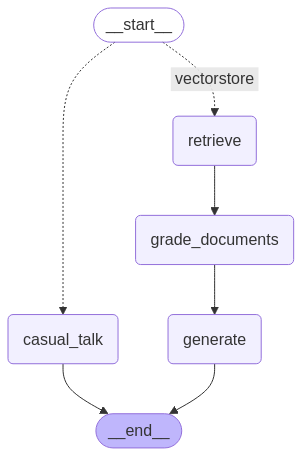

In [48]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    #  실패 시 통과
    pass


In [49]:
inputs = {
    "question": "서울시 자율주행 계획"
}

app.invoke(inputs) # workflow를 실행합니다.

------ROUTE------
---Routing to vectorstore---
------RETRIEVE------
------GRADE------
------GENERATE------


{'question': '서울시 자율주행 계획',
 'generation': AIMessage(content='서울시는 자율주행 자동차를 포함한 미래교통수단의 도입을 위해 2030년까지 간선도로급 이상 도로에서 자율주행 자동차가 운영될 수 있는 도로 인프라 환경을 조성할 계획입니다. 더 나아가, 2040년까지 서울 전역에서 자율주행차량의 운행 환경을 구축하고 수송 분담률 10%를 달성하는 것을 목표로 하고 있습니다. \n\n이를 위해 서울시는 도시 인프라 확충에 대한 지원이 필요하며, 자율주행차량과 같은 새로운 교통 수단의 정착을 위한 전략적 계획이 요구됩니다. 또한, 도심 항공교통(UAM) 기반을 마련하고, 모빌리티 허브를 서울 전역에 구축하여 다양한 교통수단과 서비스의 통합을 도모할 예정입니다. \n\n이러한 노력은 서울시의 교통 체계가 기존 교통수단과의 조화를 이루고, 안전하고 효율적인 통행을 가능하게 하는 데 기여할 것으로 기대됩니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 235, 'prompt_tokens': 1479, 'total_tokens': 1714, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-0b32d5ad-ff43-47c1-9195-e86941c395f6-0',

In [50]:
inputs = {
    "question": "잘 지내고 있어?"
}

app.invoke(inputs) # workflow를 실행합니다.

------ROUTE------
---Routing to casual_talk---
------CASUAL TALK------


{'question': '잘 지내고 있어?',
 'generation': AIMessage(content='저는 항상 잘 지내고 있어요! 당신은요? 어떻게 지내고 계신가요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 13, 'total_tokens': 37, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-ef50bdf4-6b35-4eea-9cde-f013809e04b6-0', usage_metadata={'input_tokens': 13, 'output_tokens': 24, 'total_tokens': 37, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}

In [51]:
inputs = {
    "question": "서울시의 자율주행 차량 관련 계획은 무엇이 있나요?"
}

for msg, meta in app.stream(inputs, stream_mode='messages'):
    print(msg.content, end='')


------ROUTE------
{"datasource":"vectorstore"}---Routing to vectorstore---
------RETRIEVE------
------GRADE------
{"binary_score":"yes"}{"binary_score":"yes"}{"binary_score":"yes"}{"binary_score":"no"}{"binary_score":"no"}------GENERATE------
서울시의 자율주행 차량 관련 계획은 다음과 같습니다. 

1. **운영 체계 구축**: 서울시는 자율주행 자동차의 본격 운영을 위한 체계 구축을 계획하고 있습니다. 단계적으로 2030년까지 간선도로급 이상 도로에서 자율주행차가 운영될 수 있는 도로 인프라 환경을 조성할 예정이며, 2040년까지는 서울 전역에서 자율주행 차량의 운행 환경을 구축할 목표를 가지고 있습니다.

2. **수송 분담률 목표**: 2040년까지 자율주행차량의 수송 분담률을 10% 달성하는 것을 목표로 하고 있습니다.

3. **도심 항공 교통(UAM)**: 서울은 도심 항공교통 시스템을 마련하고, 김포공항과의 연결을 포함한 시범 노선을 운영하며, 장기적으로 광역 노선도 확장할 계획입니다.

4. **모빌리티 허브 구축**: 서울 전역에 모빌리티 허브를 구축하여, 기존의 교통 시스템과 새로운 교통 수단을 연계하고 다양한 공공 서비스와 상업 기능이 결합된 지역 거점을 조성할 예정입니다.

이러한 계획들은 기술 발전에 선제적으로 대응하고, 미래의 도시 활동 변화에 따라 보다 포용적인 교통체계를 마련하기 위한 노력의 일환으로 진행되고 있습니다.